### Модель анализа точки безубыточности для ставок на падение курса USD/XTZ, измеряемых в USD:
- Пример расчёта результата в USD для ставки 1 xtz против роста курса в событие с пулом 1xtz:1xtz и итоговой динамикой 0.9 xtz

In [5]:
usd_to_xtz_start = 4.20
target_usd_to_tez_dynamics = 0.95
real_usd_to_tez_dynamics = 0.9

# Ставка против движения цены: это ставка за, в событиях где targetRate < 1:
bet_bellow_xtz = 1
bet_bellow_usd = bet_bellow_xtz * usd_to_xtz_start

pool_bellow_xtz = 1
pool_above_eq_xtz = 1
ratio = pool_above_eq_xtz / (pool_bellow_xtz + bet_bellow_xtz)

return_xtz = ratio * bet_bellow_xtz + bet_bellow_xtz
return_usd = return_xtz * real_usd_to_tez_dynamics * usd_to_xtz_start

result_usd = return_usd / bet_bellow_usd
result_usd

1.35

### Упрощённа эта модель может быть сведена к двум параметрам: ratio, real_usd_to_tez_dynamics
* targetDynamics не играет никакой роли: он меняет состав события, что сказывается на смещении ratio, но непосредственно для расчётов безубыточности ставки в USD влияние не оказывает.

In [6]:
def result_in_usd(ratio, real_usd_to_tez_dynamics):
    return (1 + ratio) * real_usd_to_tez_dynamics

result_in_usd(0.5, 0.9)

1.35

### Таблица результатов ставки при различных параметрах ratio и real_usd_to_tez_dynamics:

In [7]:
import pandas as pd
import numpy as np

usd_returns = pd.DataFrame({
    dynamics: {rate: result_in_usd(rate, dynamics) for rate in np.linspace(0, 1, 11)}
    for dynamics in np.linspace(0.5, 2, 11)
})

usd_returns#.style.background_gradient(cmap='viridis', axis=None)

,0.50,0.65,0.80,0.95,1.10,1.25,1.40,1.55,1.70,1.85,2.00
0.0,0.50,0.650,0.80,0.950,1.10,1.250,1.40,1.550,1.70,1.850,2.0
0.1,0.55,0.715,0.88,1.045,1.21,1.375,1.54,1.705,1.87,2.035,2.2
0.2,0.60,0.780,0.96,1.140,1.32,1.500,1.68,1.860,2.04,2.220,2.4
0.3,0.65,0.845,1.04,1.235,1.43,1.625,1.82,2.015,2.21,2.405,2.6
0.4,0.70,0.910,1.12,1.330,1.54,1.750,1.96,2.170,2.38,2.590,2.8
0.5,0.75,0.975,1.20,1.425,1.65,1.875,2.10,2.325,2.55,2.775,3.0
0.6,0.80,1.040,1.28,1.520,1.76,2.000,2.24,2.480,2.72,2.960,3.2
0.7,0.85,1.105,1.36,1.615,1.87,2.125,2.38,2.635,2.89,3.145,3.4
0.8,0.90,1.170,1.44,1.710,1.98,2.250,2.52,2.790,3.06,3.330,3.6
0.9,0.95,1.235,1.52,1.805,2.09,2.375,2.66,2.945,3.23,3.515,3.8


### Анализ точки безубыточности для ставок в USD:
* Точка может быть описана следующей линией:
```(1 + ratio) * real_usd_to_tez_dynamics == 1```
* breakeven: функция которая рассчитывает real_usd_to_tez_dynamics от ratio при условии что итоговый результат в USD == 1

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('whitegrid')

In [54]:
def prob_to_ratio(prob_bellow):
    """ converts poolBellow event realisation probability to
        ratio poolAbove/poolBellow """

    return (1 - prob_bellow) / prob_bellow

def ratio_breakeven(ratio):
    return 1/(1 + ratio)

def brekaven_dyamics_from_prob(prob):
    """ Calculates minimum USD/XTZ dynamics that would keep participant profitable in USD
        if probability to win is equal to prob """

    return (ratio_breakeven(prob_to_ratio(prob)) - 1)

<ipython-input-54-20801b3fb3f4>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 - prob_bellow) / prob_bellow


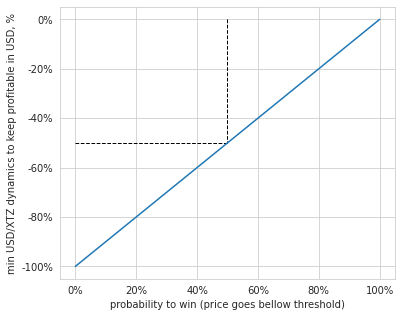

In [56]:
probs = np.linspace(0, 1, 100)
breakeven_dynamics = [brekaven_dyamics_from_prob(x) for x in probs]

ax = pd.Series(breakeven_dynamics, index=probs).plot(figsize=(6, 5))
ax.set_xlabel('probability to win (price goes bellow threshold)')
ax.set_ylabel('min USD/XTZ dynamics to keep profitable in USD, %')

plt.vlines(x=0.5, ymax=brekaven_dyamics_from_prob(0.5), ymin=0, color='k', linestyle='--', linewidth=1)
plt.hlines(xmin=0, xmax=0.5, y=brekaven_dyamics_from_prob(0.5), color='k', linestyle='--', linewidth=1)
plt.annotate('breakeven xtz_to_usd = 1 / (1 + ratio)', (1.4, 0.45))

format_func = lambda v, _: f'{v*100:.0f}%'
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

Доходность ставки в USD зависит от итоговой динамики курса и соотношения вероятности победы после ставки. Точка безубыточности для ставок на падение курса XTZ, измеряемая в USD (пограничные условия, для получения положительного результата в USD, в случае победы при ставке на падение XTZ) отражены на графике выше.

1. При prob -> 100% (когда все ожидают падения курса) результат ставки полностью соответствует движению курса (потенциальный выйгрыш стремится к нулю).
2. При prob == 50% (когда оба пула сбалансированы), результат ставки будет убыточным в USD только если курс упадёт больше чем в два раза.
3. При prob -> 0% (когда все считают что курс вырастет), выйгрыш ставки на падение курса будет давать несоизмеримо большее преимущество чем падение курса

### Также нужно обратить внимание на то, что:
* bet в USD будет зависить от времени ставки, курс во время ставки может меняться